In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import clip  # openai-clip
from PIL import Image
import numpy as np
import cv2  # opencv-python
import os
import math
import warnings
from typing import Union, Tuple, List
from types import SimpleNamespace  # yacs.config.CfgNode の代用

In [27]:
from models.model_builder import VideoChangeWeightedCLIP, vcw_clip_load
from datasets.build import read_label_file_custom, read_description_csv_custom
from utils.tools import generate_text
from datasets.build import BaseDataset, VideoDataset, build_dataloader
from utils.config import _C

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import math
import types # モンキーパッチ（メソッドの動的置き換え）に必要
from typing import Union, Tuple


# === 1. 可視化アセット (simmap) ===
# (ユーザーが提示したコード)

def get_visual_patch_tokens(model, img_tensor):
    # --- forward like CLIP, but keep patch tokens ---
    visual = model.visual
    
    # (ダミー対応: visual が nn.Linear の場合、ViTロジックをスキップ)
    if not hasattr(visual, "conv1"):
        print("[ダミー] get_visual_patch_tokens: ViTロジックをスキップ。ダミー値を返します。")
        B, C, H, W = img_tensor.shape
        Hp, Wp = 14, 14 # (224/16)
        N = Hp * Wp
        D = 512 # 仮
        patch_tokens = torch.randn(B, N, D, device=img_tensor.device)
        patch_tokens = patch_tokens / patch_tokens.norm(dim=-1, keepdim=True)
        return patch_tokens, (Hp, Wp)
        
    # (本来の ViT ロジック)
    assert visual.__class__.__name__ == "VisionTransformer", "Use ViT-* CLIP"
    x = img_tensor  # (B,3,H,W)
    x = visual.conv1(x)  # (B, C, H/patch, W/patch)
    grid = (x.shape[-2], x.shape[-1])
    x = x.reshape(x.shape[0], x.shape[1], -1)  # (B,C,N)
    x = x.permute(0, 2, 1)  # (B,N,C)
    cls_token = visual.class_embedding.to(x.dtype)
    cls = cls_token + torch.zeros(x.shape[0], 1, x.shape[-1], dtype=x.dtype, device=x.device)
    x = torch.cat([cls, x], dim=1)
    x = x + visual.positional_embedding.to(x.dtype)
    x = visual.ln_pre(x)
    x = x.permute(1, 0, 2)  # (S,B,C)
    x = visual.transformer(x)
    x = x.permute(1, 0, 2)  # (B,S,C)
    patch_tokens = x[:, 1:, :]  # (B, N, C_vit)
    if hasattr(visual, "proj") and visual.proj is not None:
        patch_tokens = patch_tokens @ visual.proj  # (B, N, D)
    patch_tokens = patch_tokens / patch_tokens.norm(dim=-1, keepdim=True)
    return patch_tokens, grid

def simmap(image_tensor, text_embed, model, device, agg="max", topk=1, meta=None):
    patch_tokens, (Hp, Wp) = get_visual_patch_tokens(model, image_tensor.to(device))  # (B,N,D), grid
    B, N, D = patch_tokens.shape
    H, W = image_tensor.shape[-2:]

    if text_embed.dim() == 1:
        t = text_embed / text_embed.norm()
        sim = torch.einsum("bnd,d->bn", patch_tokens, t.to(patch_tokens.dtype))  # (B,N)
    else:
        te = text_embed / text_embed.norm(dim=-1, keepdim=True)
        sim_all = torch.einsum("bnd,pd->bnp", patch_tokens, te.to(patch_tokens.dtype))  # (B,N,P)
        sim, _ = sim_all.max(dim=-1)  # (B,N)

    sim_map = sim.view(B, 1, Hp, Wp)
    sim_up = F.interpolate(sim_map, size=(H, W), mode="bicubic", align_corners=False)
    sim_up = (sim_up - sim_up.amin(dim=[2,3], keepdim=True)) / (sim_up.amax(dim=[2,3], keepdim=True) - sim_up.amin(dim=[2,3], keepdim=True) + 1e-6)

    vals, idx = sim.topk(k=topk, dim=1)  # (B,topk)
    r = (idx // Wp).unsqueeze(-1)  # (B,topk,1)
    c = (idx % Wp).unsqueeze(-1)  # (B,topk,1)
    topk_rc = torch.cat([r, c], dim=-1)  # (B,topk,2)
    
    patch_h = H // Hp
    patch_w = W // Wp
    x1 = (c * patch_w).squeeze(-1)
    y1 = (r * patch_h).squeeze(-1)
    x2 = x1 + patch_w
    y2 = y1 + patch_h
    topk_box_px = torch.stack([x1, y1, x2, y2], dim=-1)  # (B,topk,4)

    return sim_up, idx, topk_rc, topk_box_px

def save_overlay(img: Image.Image, sim_up: torch.Tensor, out_png: str, alpha=0.45):
    H, W = sim_up.shape[-2], sim_up.shape[-1]
    fig = plt.figure(figsize=(W/100, H/100), dpi=100)
    ax = plt.axes([0,0,1,1]); ax.axis("off")
    ax.imshow(img)
    ax.imshow(sim_up[0,0].detach().cpu().numpy(), cmap="jet", alpha=alpha, interpolation="bilinear")
    fig.savefig(out_png, dpi=200, bbox_inches="tight", pad_inches=0)
    plt.close(fig)

# === 2. モンキーパッチ用の新しい forward メソッド ===

def forward_for_visualization(
    self,
    video_frames: torch.Tensor,
    text: torch.Tensor,
    animal_labels: torch.Tensor,
    description_labels: torch.Tensor,
    *args, **kwargs
):
    """
    VideoChangeWeightedCLIP.forward のオーバーライド（モンキーパッチ用）。
    ご提示いただいた最新のクラスロジック（attn_btn）に基づき、
    可視化に必要な 'attn_btn' と 'fused_action_vectors' を追加で返します。
    """
    
    # --- 元の forward メソッドのロジック (ステップ 1-3) ---
    if not args:
        raise ValueError("Missing required argument 'animal_pred' in *args for Lookup Mode.")
    animal_pred = args[0]
    B = video_frames.shape[0]

    # 1) フレーム特徴
    frame_features = self.encode_video_frames(video_frames)  # (B, T, D)
    T_len = frame_features.shape[1]

    # 2) Temporal Transformer
    tt_out = self.temporal_transformer(frame_features.float())
    
    # (ダミー対応: tt_out が (B,D) の場合)
    if tt_out.dim() == 2:
        # (B,D) -> (B,T,D) にブロードキャスト (ダミー用)
        print("[ダミー] TemporalTransformer出力を (B,D) から (B,T,D) にブロードキャストします。")
        refined_frames = tt_out.unsqueeze(1).expand(-1, T_len, -1)
        video_vector = tt_out
    elif tt_out.dim() == 3 and tt_out.shape[:2] == (B, T_len):
        refined_frames = tt_out  # (B, T, D)
        video_vector = refined_frames.mean(dim=1)
    else:
        refined_frames = frame_features
        video_vector = tt_out if tt_out.dim() == 2 else frame_features.mean(dim=1)

    # 3) テキスト側 + 動物コンテキスト
    with torch.no_grad():
        # 行動テキスト（Q）
        if text.dim() == 3:
            n_classes, n_prompts, _ = text.shape
            text_input = text.view(n_classes * n_prompts, -1)
        else:
            n_classes, _ = text.shape
            n_prompts = 1
            text_input = text
        action_vectors_q = self.encode_text(text_input)
        if n_prompts > 1:
            action_vectors_q = action_vectors_q.view(n_classes, n_prompts, -1)
            action_vectors_q, _ = torch.max(action_vectors_q, dim=1)
        N = n_classes

        # 説明テキスト（K/V）
        if description_labels.dim() == 3:
            n_desc, n_prompts_desc, _ = description_labels.shape
            desc_input = description_labels.view(n_desc * n_prompts_desc, -1)
        else:
            n_desc, _ = description_labels.shape
            n_prompts_desc = 1
            desc_input = description_labels
        description_vectors_kv = self.encode_text(desc_input)
        if n_prompts_desc > 1:
            description_vectors_kv = description_vectors_kv.view(n_desc, n_prompts_desc, -1)
            description_vectors_kv, _ = torch.max(description_vectors_kv, dim=1)

        if N != n_desc:
            raise ValueError(
                f"Action(Q)/Description(K/V) class count mismatch: text(Q) ({N}) vs description_labels(K/V) ({n_desc})."
            )

        # 動物コンテキスト
        if self.animal_vectors_lookup_table is None:
            raise RuntimeError("Animal lookup table has not been pre-computed. Call model.precompute_animal_lookup() after initialization.")
        lookup_table_cpu = self.animal_vectors_lookup_table
        a_classes = lookup_table_cpu.shape[0]
        if B != animal_pred.shape[0]:
            raise ValueError(f"Batch size mismatch: video_frames ({B}) vs animal_pred ({animal_pred.shape[0]})")
        if a_classes != animal_pred.shape[1]:
            raise ValueError(f"Animal class mismatch: lookup ({a_classes}) vs animal_pred ({animal_pred.shape[1]})")
        current_device = animal_pred.device
        lookup_table = lookup_table_cpu.to(current_device)

        if animal_pred.dim() == 1:
            # animal_pred が 1D (A) の場合 (B=1 で squeeze() された場合)
            # (A) -> (1, 1, A) にする
            animal_pred_expanded = animal_pred.unsqueeze(0).unsqueeze(0)
        elif animal_pred.dim() == 2:
            # animal_pred が 2D (B, A) の場合 (期待される動作)
            # (B, A) -> (B, 1, A) にする
            animal_pred_expanded = animal_pred.unsqueeze(1)
        else:
            raise ValueError(f"animal_pred の形状が 1D または 2D ではありません (形状: {animal_pred.shape})")

        lookup_table_expanded = lookup_table.unsqueeze(0).expand(B, -1, -1)
        animal_vectors = torch.bmm(
            animal_pred_expanded.to(lookup_table_expanded.dtype),
            lookup_table_expanded
        )  # (B, 1, D)

    # --- 元の forward メソッドのロジック (ステップ 4-6) ---
    
    # 4) Fuser
    action_query_vectors = self.action_fuser(
        query_vectors=action_vectors_q.float(),
        context_vectors=description_vectors_kv.float()
    )  # (N, D)
    Q = action_query_vectors.unsqueeze(0).expand(B, -1, -1)  # (B, N, D)
    K = animal_vectors  # (B, 1, D)
    fused_action_vectors = self.semantic_fuser(query_vectors=Q, context_vectors=K)  # (B, N, D)

    # 5) 時間方向 Softmax 重み付きプール
    eps = 1e-6
    frame_norm = refined_frames / (refined_frames.norm(dim=-1, keepdim=True) + eps)      # (B, T, D)
    text_norm = fused_action_vectors / (fused_action_vectors.norm(dim=-1, keepdim=True) + eps)  # (B, N, D)

    sim_btn = torch.bmm(frame_norm, text_norm.transpose(1, 2))  # (B, T, N)
    
    # ▼▼▼ 可視化対象の時間Attention ▼▼▼
    attn_btn = F.softmax(sim_btn, dim=1) # dim=1 (時間方向) でSoftmax
    
    pooled_video_vectors = torch.einsum("btn,btd->bnd", attn_btn, refined_frames)

    # 6) 最終コサイン類似度
    pooled_norm = pooled_video_vectors / (pooled_video_vectors.norm(dim=-1, keepdim=True) + eps)
    fused_norm = text_norm
    
    if getattr(self, "use_logit_scale", True):
        logit_scale = self.logit_scale.exp()
    else:
        logit_scale = torch.tensor(1.0, device=pooled_norm.device, dtype=pooled_norm.dtype)

    logits = logit_scale * (pooled_norm * fused_norm).sum(dim=-1)  # (B, N)
    
    # --- 可視化のための戻り値の追加 ---
    # 元: return logits, video_vector
    # 新:
    return logits, video_vector, attn_btn, fused_action_vectors

# === 3. 統合可視化関数 (修正版) ===

def visualize_temporal_spatial_attention(
    model, 
    video_frames_tensor: torch.Tensor, # (B, T, C, H, W)
    pil_images: list,                  # T個のPIL.Imageのリスト (B=0用)
    text_inputs: torch.Tensor,         # (N, 77)
    animal_labels: torch.Tensor,       # (A, 77)
    description_labels: torch.Tensor,  # (N, 77)
    animal_pred: torch.Tensor,         # (B, A)
    
    # --- タイトル表示用の引数 ---
    label_list: list,                  # クラス名のリスト (e.g., [['running', '0'], ...])
    gt_action_label_id: int,           # G-Tの行動ID (バッチ0のもの)
    
    target_batch_idx: int = 0,
    target_class_idx: int = 0,         # 可視化するNクラスのうちのインデックス
    output_png: str = "temporal_spatial_map.png",
    show_temporal_border: bool = True, # 枠色のON/OFF
    spatial_alpha: float = 0.45,
    border_width: float = 10.0
):
    """
    時間Attention(attn_btn)と空間Attention(simmap)を組み合わせて可視化する。
    [修正点] simmap の呼び出し (中略部分) を明記。
    """
    
    model.eval()
    device = next(model.parameters()).device
    
    # --- 1. モデル実行 ---
    print("モンキーパッチされた forward パスを実行中...")
    try:
        with torch.no_grad():
            outputs = model.forward( # .forward() を明示的に呼び出す
                video_frames_tensor.to(device), 
                text_inputs.to(device), 
                animal_labels.to(device), 
                description_labels.to(device), 
                animal_pred.to(device) # *args
            )
            if not isinstance(outputs, tuple) or len(outputs) != 4:
                print("--- エラー ---")
                print("モンキーパッチされた 'forward_for_visualization' は 4つの値を返す必要があります。")
                return

            logits, _, attn_btn, fused_action_vectors = outputs

    except Exception as e:
        print(f"モデル実行中にエラーが発生しました: {e}")
        raise e # 根本原因を修正するため再スロー

    B, T, C, H, W = video_frames_tensor.shape
    
    # (PIL画像リストの検証)
    if not pil_images or len(pil_images) != T:
        print(f"警告: PIL画像の数 ({len(pil_images) if pil_images else 0}) がフレーム数 ({T}) と一致しません。")
        print("video_frames_tensorからPIL画像を強制生成します。")
        pil_images = []
        for t in range(T):
            frame_np = (
                video_frames_tensor[target_batch_idx, t]
                .permute(1, 2, 0)
                .cpu()
                .float() 
                .numpy()
            )
            frame_np = np.clip(frame_np * 255, 0, 255).astype(np.uint8)
            pil_images.append(Image.fromarray(frame_np))

    # --- 2. 可視化対象のデータを抽出 ---
    temporal_weights = attn_btn[target_batch_idx, :, target_class_idx].cpu().numpy()
    target_text_embed = fused_action_vectors[target_batch_idx, target_class_idx, :].to(device)

    # --- 3. 空間マップをフレームごとに計算 (★エラー箇所) ---
    print("フレームごとに空間Attentionマップ (simmap) を計算中...")
    spatial_sim_maps = []
    
    # (T=8 フレームでループ)
    for t in range(T):
        
        # ▼▼▼ (中略) されていたコードは以下の部分です ▼▼▼
        # (sim_up を定義する)
        
        # (t)番目のフレームテンソル (1, C, H, W)
        frame_tensor_t = video_frames_tensor[target_batch_idx, t, :, :, :].unsqueeze(0).to(device)
        
        with torch.no_grad():
            # simmap を呼び出し、sim_up を受け取る
            sim_up, _, _, _ = simmap(
                frame_tensor_t, 
                target_text_embed, 
                model, 
                device
            )
        # ▲▲▲ (中略) 部分はここまで ▲▲▲
        
        # これで sim_up が定義されたため、エラーが解消されます
        spatial_sim_maps.append(sim_up[0].cpu()) # (1, H, W)

    # --- 4. Matplotlib で可視化 ---
    print("可視化画像を生成中...")
    
    # (時間ボーダー色の計算)
    norm_weights = (temporal_weights - temporal_weights.min()) / (temporal_weights.max() - temporal_weights.min() + 1e-6)
    
    # (get_cmap の DeprecationWarning は matplotlib の仕様であり、動作に問題ありません)
    try:
        cmap = cm.get_cmap("coolwarm") 
    except AttributeError: # matplotlib 3.7+
        cmap = plt.colormaps.get_cmap("coolwarm")
        
    border_colors = [cmap(w) for w in norm_weights]

    fig, axes = plt.subplots(1, T, figsize=(W * T / 100, H / 100 + 1.2), dpi=100)
    if T == 1: axes = [axes] 

    for t in range(T):
        # (画像描画)
        ax = axes[t]
        img = pil_images[t]
        sim_map_t = spatial_sim_maps[t]
        ax.axis("off")
        ax.imshow(img)
        ax.imshow(sim_map_t[0].detach().numpy(), cmap="jet", alpha=spatial_alpha, interpolation="bilinear")
        
        if show_temporal_border:
            color = border_colors[t]
            for spine in ax.spines.values():
                spine.set_visible(True)
                spine.set_color(color)
                spine.set_linewidth(border_width)
        
        ax.set_title(f"Frame {t}\nWeight={temporal_weights[t]:.3f}", fontsize=8)

    # --- 4b. タイトル生成ロジック (前回修正済み) ---
    with torch.no_grad():
        pred_logits_b0 = logits[target_batch_idx] 
        pred_id_b0 = torch.argmax(pred_logits_b0).item()
        
        def get_label_name(lst, idx):
            if idx < 0 or idx >= len(lst): return "N/A"
            item = lst[idx]
            return item[0] if isinstance(item, (list, tuple)) else item

        pred_name = get_label_name(label_list, pred_id_b0)
        gt_name = get_label_name(label_list, gt_action_label_id)
        viz_target_name = get_label_name(label_list, target_class_idx)

    title_pred_gt = f"Pred: {pred_name} (ID: {pred_id_b0})  |  GT: {gt_name} (ID: {gt_action_label_id})"
    title_viz = f"Visualizing for: '{viz_target_name}' (Class {target_class_idx}) | Border: {'ON' if show_temporal_border else 'OFF'}"

    fig.suptitle(f"{title_pred_gt}\n{title_viz}", y=1.05, fontsize=10)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95]) 
    plt.show()

In [34]:
# --- (1) 必要なインポートの追加 ---
import torch.distributed as dist
from torch.utils.data import DataLoader, SubsetRandomSampler
from functools import partial
import mmcv
from mmcv.parallel import collate as mmcv_collate # build_dataloader で使用
import re # VideoDataset で使用される可能性
import os.path as osp # VideoDataset で使用される可能性

# --- (2) build_dataloader を実行するためのヘルパー ---

def init_dummy_distributed():
    """
    Jupyter/スクリプトで build_dataloader を実行するためのダミーの分散環境を初期化
    """
    if not dist.is_initialized():
        # dist.init_process_group(backend='nccl', init_method='tcp://127.0.0.1:23456', world_size=1, rank=0)
        # NCCLがない場合、'gloo' を使用
        try:
            dist.init_process_group(backend='gloo', init_method='tcp://127.0.0.1:23456', world_size=1, rank=0)
            print("ダミーの分散環境 (gloo) を初期化しました。")
        except Exception as e:
            print(f"分散環境の初期化に失敗: {e}。すでに初期化済みかもしれません。")

def get_img_norm_cfg():
    """
    CLIP (ViT-B/16) の標準的な正規化設定を返す
    (build_dataloader の img_norm_cfg が不明なため)
    """
    return {
        'mean': [0.48145466, 0.4578275, 0.40821073],
        'std': [0.26862954, 0.26130258, 0.27577711]
    }

def denormalize_to_pil_list(video_tensor, img_norm_cfg):
    """
    (B, T, C, H, W) の正規化済みテンソルを PIL 画像のリスト (T枚) に戻す
    """
    mean = torch.tensor(img_norm_cfg['mean'], device=video_tensor.device).view(1, 1, 3, 1, 1)
    std = torch.tensor(img_norm_cfg['std'], device=video_tensor.device).view(1, 1, 3, 1, 1)
    
    # 0番目のバッチを選択 (B=0)
    tensor_b0 = video_tensor[0:1] # (1, T, C, H, W)
    
    # 逆正規化
    denorm_tensor = tensor_b0 * std + mean
    denorm_tensor = denorm_tensor.clamp(0, 1) # [0, 1] にクリップ
    
    pil_images = []
    for t in range(denorm_tensor.shape[1]): # T フレームでループ
        frame_tensor = denorm_tensor[0, t] # (C, H, W)
        
        # (C, H, W) -> (H, W, C) -> numpy -> PIL
        frame_np = frame_tensor.permute(1, 2, 0).cpu().numpy()
        frame_uint8 = (frame_np * 255).astype(np.uint8)
        pil_images.append(Image.fromarray(frame_uint8))
        
    return pil_images

# (build_dataloader, VideoDataset, BaseDataset などの関数/クラス定義が
#  この場所でインポートまたは定義されている必要があります)

In [46]:
import torch
import torch.nn.functional as F
import types  # モンキーパッチに必要
import os
import clip
import pandas as pd
from PIL import Image
import numpy as np
from yacs.config import CfgNode as CN  # configのロードにyacsを使用
import yaml # load_config_from_string で使用


# === ヘルパー関数 (Configロード用 - これは残す) ===

config = _C.clone()

import torch
import torch.nn.functional as F
import types  # モンキーパッチに必要
import os
import os.path as osp # _update_config_from_file, VideoDataset で使用
import clip
import pandas as pd
from PIL import Image
import numpy as np
import yaml # _update_config_from_file で使用
from yacs.config import CfgNode as CN

# (分散環境・データローダー・モデル定義のためのインポート)
import torch.distributed as dist
from torch.utils.data import DataLoader, SubsetRandomSampler
from functools import partial
import mmcv
from mmcv.parallel import collate as mmcv_collate
import re

# --- 必要なモジュール/関数のインポート (前提) ---
# 以下のモジュール・関数は、このスクリプトと同じスコープに
# インポート/定義されている必要があります。

# [プロジェクト (utils) から]
try:
    from utils.config import _C
except ImportError:
    print("エラー: from utils.config import _C が失敗しました。")
    print("utils/config.py へのパスが通っているか確認してください。")
    raise


# === ヘルパー関数 (Configロード用 - ユーザー提供) ===

def _update_config_from_file(config, cfg_file):
    config.defrost()
    with open(cfg_file, 'r') as f:
        yaml_cfg = yaml.load(f, Loader=yaml.FullLoader)

    for cfg in yaml_cfg.setdefault('BASE', ['']):
        if cfg:
            _update_config_from_file(
                config, os.path.join(os.path.dirname(cfg_file), cfg)
            )
    print('=> merge config from {}'.format(cfg_file))
    config.merge_from_file(cfg_file)
    config.freeze()

config = _C.clone()
config_file_path = 'configs/mmnet/Proposed_classifier_backbone.yaml'
if not os.path.exists(config_file_path):
    raise FileNotFoundError(f"Config ファイルが見つかりません: {config_file_path}")
_update_config_from_file(config, config_file_path)

device = "cuda" if torch.cuda.is_available() else "cpu"

# (2. モデルのロード)
# `vcw_clip_load` は、Config に基づいてモデル構造を構築 (HF_FINETUNED_PATH を使用)
try:
    model = vcw_clip_load(config, device)
except NameError:
    print("エラー: `vcw_clip_load` が定義されていません。")
    print("`vcw_clip_load` とその依存関数 (build_vcw_model など) を定義/インポートしてください。")
    raise

# (3. 学習済みチェックポイントのロード)
# (変更なし: このロジックは main.py の load_checkpoint と実質的に同等の処理を行っている)
checkpoint_path = '/home/nakagawa/compare_method/original/Animal-CLIP/exp_proposed_final_classifier_backbone/best.pth'
if not os.path.exists(checkpoint_path):
    print(f"警告: チェックポイント {checkpoint_path} が見つかりません。")
else:
    print(f"チェックポイントをロード中: {checkpoint_path}")
    state_dict = torch.load(checkpoint_path, map_location='cpu')
    
    if 'model' in state_dict:
        state_dict = state_dict['model']
        
    state_dict_cleaned = {}
    for k, v in state_dict.items():
        if k.startswith('module.'):
            state_dict_cleaned[k[7:]] = v
        else:
            state_dict_cleaned[k] = v
            
    try:
        model.load_state_dict(state_dict_cleaned, strict=True)
        print("モデルのチェックポイント (best.pth) のロードに成功しました。")
    except RuntimeError as e:
        print(f"--- チェックポイントのロードに失敗しました (strict=True) ---")
        print(f"エラー: {e}")
        print("strict=False (非推奨) で再試行します...")
        model.load_state_dict(state_dict_cleaned, strict=False)
        print("strict=False でのロードに成功しました (一部のキーが不一致の可能性があります)。")

model.to(device).eval()


# (4. ★★★ forward メソッドのモンキーパッチ ★★★)
# (変更なし)
try:
    model.forward = types.MethodType(forward_for_visualization, model)
    print(f"モデルの forward メソッドを {forward_for_visualization.__name__} でオーバーライドしました。")
except NameError:
    print("エラー: `forward_for_visualization` が定義されていません。")
    raise

# (5. ▼▼▼ 修正セクション ▼▼▼)
# (ラベルとテキスト入力のロードを main.py のロジックに変更)
N = config.DATA.NUM_CLASSES
A = config.DATA.NUM_ANIMAL_CLASSES
T = config.DATA.NUM_FRAMES

try:
    print("\n--- main.py のロジックに基づきテキスト入力をロード ---")
    # (前提: read_label_file_custom, generate_text などがインポート済み)

    # 1. Actionラベル (Q) のロード
    print("########## loading action labels (Q) ##########")
    text_data = read_label_file_custom(config.DATA.LABEL_LIST)
    text_inputs = generate_text(text_data, config.DATA.NUM_CLASSES, split=False)
    # 可視化のファイル名用に、生のテキストリストも保持する
    label_list = text_data 
    print(f"Loaded Action Labels (Q) shape: {text_inputs.shape}")

    # 2. Description (K/V) のロード
    if not config.DATA.description:
         raise ValueError("config.DATA.description (for K/V) must be set for this VCW-CLIP model.")
    print("########## loading descriptions (K/V) ##########")
    description_data = read_description_csv_custom(config.DATA.description, header=False)
    description_labels = generate_text(description_data, config.DATA.NUM_CLASSES, split=config.DATA.SPLIT_DESCRIPTION)
    print(f"Loaded Description (K/V) shape: {description_labels.shape}")

    # 3. Animalラベル
    if config.DATA.animal_description:
        print("########## using animal descrition ##########")
        animal_data = read_description_csv_custom(config.DATA.animal_description, header=False)
        animal_labels = generate_text(animal_data, config.DATA.NUM_ANIMAL_CLASSES)
    else:
        print("########## loading animal labels (from list) ##########")
        animal_data = read_label_file_custom(config.DATA.ANIMAL_LABEL_LIST)
        animal_labels = generate_text(animal_data, config.DATA.NUM_ANIMAL_CLASSES)
    print(f"Loaded Animal Labels shape: {animal_labels.shape}")

    # 最終的なテンソルをデバイスに移動
    text_inputs = text_inputs.to(device)
    animal_labels = animal_labels.to(device)
    description_labels = description_labels.to(device)

    print(f"テキスト入力をロードしました: Actions={N}件, Animals={A}件")

except NameError as e:
    print(f"エラー: {e}")
    print("`read_label_file_custom`, `read_description_csv_custom`, `generate_text` などの関数が定義/インポートされていません。")
    raise
except FileNotFoundError as e:
    print(f"エラー: ラベルファイルが見つかりません: {e.filename}")
    print("CONFIG のファイルパスを確認してください。")
    raise
except Exception as e:
    print(f"テキスト入力のロード中にエラー: {e}")
    raise
# (▲▲▲ 修正セクションここまで ▲▲▲)


# (6. ★★★ 実データと予測値のロード ★★★)

B = 1 # 可視化はバッチサイズ1で実施
H, W = 224, 224 # (configから取得しても良い)

# (6-1. 分散環境の初期化)
init_dummy_distributed()

# (6-2. img_norm_cfg の定義)
# (build_dataloader 内で img_norm_cfg が定義されていないため、ここで定義)
img_norm_cfg = get_img_norm_cfg()

# 簡易ロガー (logger がない場合)
class DummyLogger:
    def info(self, msg): print(msg)

# build_dataloader を呼び出し (train_loader は不要)
_, _, _, val_loader = build_dataloader(DummyLogger(), config)
print("\n検証データローダー (val_loader) のビルドに成功しました。")

=> merge config from configs/mmnet/Proposed_classifier_backbone.yaml
--- Loading Fine-Tuned HF Model from /home/nakagawa/large_dataset/ap_10k/clip_adapter_classifier/ for VCW-CLIP ---
--- Converting HF state_dict to OpenAI format ---
Conversion complete.
[VCW-CLIP] local_contrast_state not found at: /home/nakagawa/large_dataset/ap_10k/clip_adapter_classifier/local_contrast_state.pt. Proceeding without adapter.
Keys not loaded (expected for VCW-CLIP): ['temporal_transformer.cls_token', 'temporal_transformer.positional_embedding', 'temporal_transformer.resblocks.0.attn.in_proj_weight', 'temporal_transformer.resblocks.0.attn.in_proj_bias', 'temporal_transformer.resblocks.0.attn.out_proj.weight', 'temporal_transformer.resblocks.0.attn.out_proj.bias', 'temporal_transformer.resblocks.0.ln_1.weight', 'temporal_transformer.resblocks.0.ln_1.bias', 'temporal_transformer.resblocks.0.mlp.c_fc.weight', 'temporal_transformer.resblocks.0.mlp.c_fc.bias', 'temporal_transformer.resblocks.0.mlp.c_proj.we

/tmp/ipykernel_372516/2285271782.py:90: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, map_location='cpu')


モデルのチェックポイント (best.pth) のロードに成功しました。
モデルの forward メソッドを forward_for_visualization でオーバーライドしました。

--- main.py のロジックに基づきテキスト入力をロード ---
########## loading action labels (Q) ##########
Loaded Action Labels (Q) shape: torch.Size([12, 77])
########## loading descriptions (K/V) ##########
Loaded Description (K/V) shape: torch.Size([12, 10, 77])
########## using animal descrition ##########
Loaded Animal Labels shape: torch.Size([173, 50, 77])
テキスト入力をロードしました: Actions=12件, Animals=173件
########### loading data ##########
########### train data loaded ############
########### loading data ##########
########### val data loaded ############

検証データローダー (val_loader) のビルドに成功しました。


random extract num: 15


val_loader から1バッチ取得しました。
ビデオテンソル形状 (B, T, C, H, W): torch.Size([2, 8, 3, 224, 224])
8フレーム分の PIL イメージを逆正規化により生成しました。
ローダーから取得した 'animal' テンソルの形状: torch.Size([2, 173])
G-T Animal ラベル (B, A) を animal_pred として使用します: torch.Size([2, 173])
動物ルックアップテーブルを計算中...
--- Pre-computing Animal Lookup Table (with mini-batching) ---
Encoding 8650 animal prompts in batches of 64...
Encoding complete.
--- Animal Lookup Table pre-computed. Shape: (173, 512) ---

--- 可視化を実行します ---


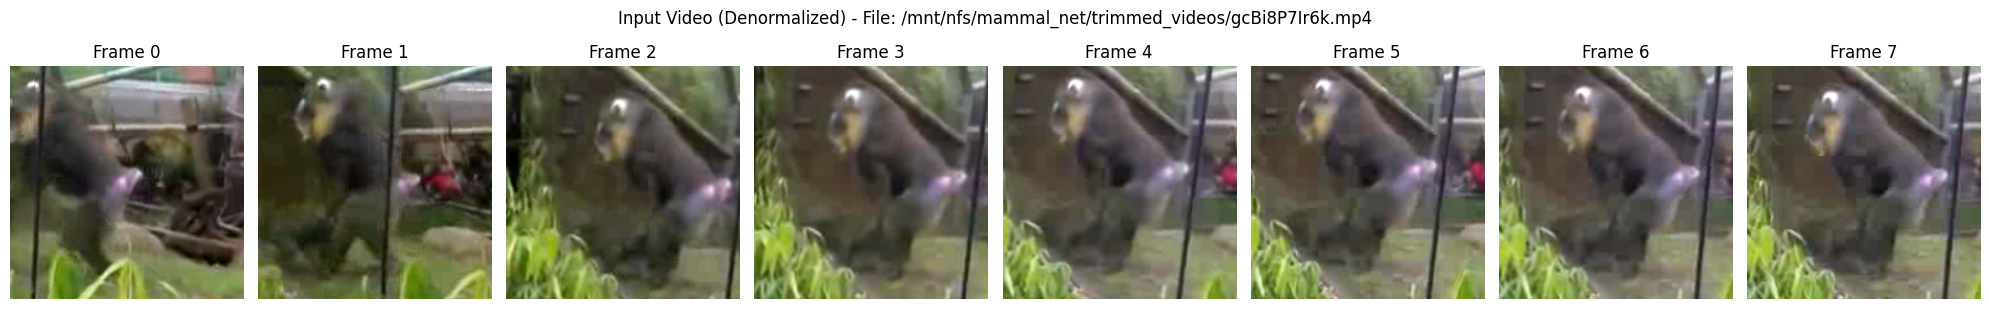

対象クラス: ID=0, Name='drinks_water'
モンキーパッチされた forward パスを実行中...
フレームごとに空間Attentionマップ (simmap) を計算中...
可視化画像を生成中...


/tmp/ipykernel_372516/3022259386.py:345: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("coolwarm")


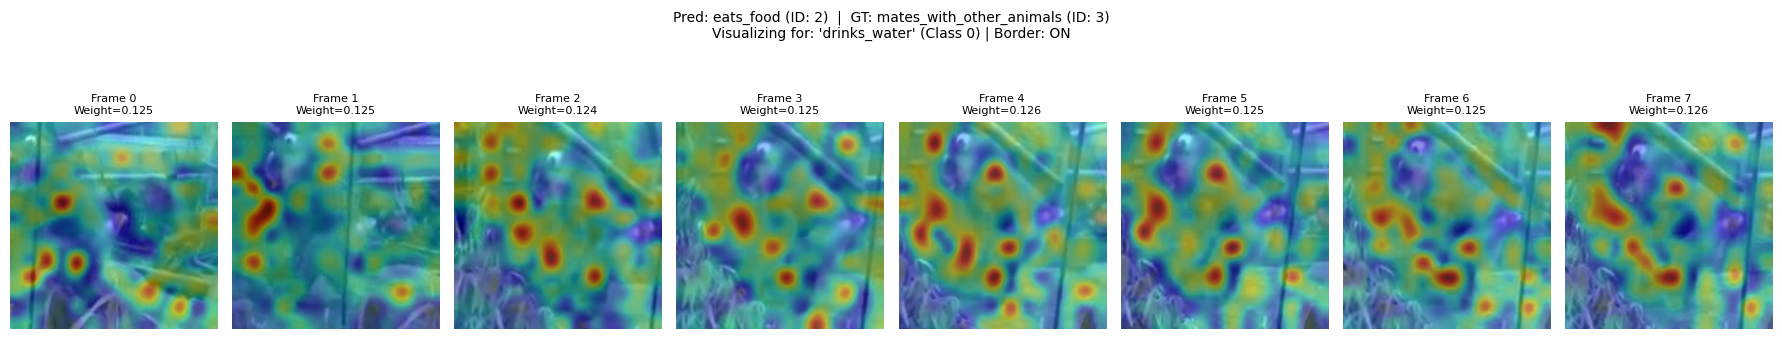

In [ ]:
# (6-4. 1バッチ取得)
import random;
num = 15
print(f"random extract num: {num}")
try:
    for _ in range(num):
        batch = next(iter(val_loader))
    print(f"val_loader から1バッチ取得しました。")
except Exception as e:
    print(f"val_loader からのデータ取得に失敗: {e}")
    print("データセットのパス (config.DATA.ROOT) が正しいか確認してください。")
    raise

# (6-5. テンソルと PIL イメージの準備)
# val_pipeline から 'imgs' (正規化済み) を取得
# mmcv_collate は (B, T, C, H, W) を (B, C, T, H, W) にする可能性があるため、
# 期待する (B, T, C, H, W) 形式に整形する
raw_imgs_tensor = batch['imgs'].to(device)

if raw_imgs_tensor.shape[1] == T and raw_imgs_tensor.shape[2] == 3:
    # (B, T, C, H, W) - 期待通り
    video_frames_tensor = raw_imgs_tensor
    print(f"ビデオテンソル形状 (B, T, C, H, W): {video_frames_tensor.shape}")
elif raw_imgs_tensor.shape[1] == 3 and raw_imgs_tensor.shape[2] == T:
    # (B, C, T, H, W) - 軸を入れ替え
    video_frames_tensor = raw_imgs_tensor.permute(0, 2, 1, 3, 4) # (B, T, C, H, W)
    print(f"ビデオテンソル形状 (B, C, T, H, W) を (B, T, C, H, W) に修正: {video_frames_tensor.shape}")
else:
    print(f"警告: 予期しないテンソル形状: {raw_imgs_tensor.shape}")
    video_frames_tensor = raw_imgs_tensor # そのまま使用

# `pil_images` を逆正規化して生成
pil_images = denormalize_to_pil_list(video_frames_tensor, img_norm_cfg)
print(f"{T}フレーム分の PIL イメージを逆正規化により生成しました。")

# (6-6. animal_pred の準備)
# val_pipeline から 'animal' (G-T ラベル) を取得
gt_animal_tensor = batch['animal'].to(device)
A = config.DATA.NUM_ANIMAL_CLASSES # 173

print(f"ローダーから取得した 'animal' テンソルの形状: {gt_animal_tensor.shape}")

# animal_pred が (B, A) 形状であることを保証する
if gt_animal_tensor.dim() == 2 and gt_animal_tensor.shape[1] == A:
    # 形状が (B, A) (例: 2, 173) の場合。これが animal_pred
    animal_pred = gt_animal_tensor.float()
    print(f"G-T Animal ラベル (B, A) を animal_pred として使用します: {animal_pred.shape}")
    
elif gt_animal_tensor.dim() == 1 or (gt_animal_tensor.dim() == 2 and gt_animal_tensor.shape[1] == 1):
    # 形状が (B) または (B, 1) の場合 (クラスID)
    print(f"G-T Animal ID を One-Hot (B, A) に変換します...")
    if gt_animal_tensor.dim() == 2:
        gt_animal_ids = gt_animal_tensor.squeeze(-1) # (B, 1) -> (B)
    else:
        gt_animal_ids = gt_animal_tensor # (B)
    
    animal_pred = F.one_hot(gt_animal_ids.long(), num_classes=A).float()
    print(f"One-Hot 変換後の animal_pred 形状: {animal_pred.shape}")
    
else:
    # エラーハンドリング (開発理念: 早期にエラーを検出し、明確なメッセージを提供)
    raise ValueError(
        f"batch['animal'] の形状 ({gt_animal_tensor.shape}) が (B, A) または (B, 1) のどちらでもありません。\n"
        f"データローダー (VideoDataset) または (mmcv_collate) の 'animal' の返り値を確認してください。"
    )

# (7. 動物ルックアップテーブルの計算 - 必須)
# (変更なし: `animal_labels` は (5) で正しくテンソルとして生成されている)
print("動物ルックアップテーブルを計算中...")
model.precompute_animal_lookup(animal_labels, device=device)

# (8. 可視化の実行)
# (変更なし: `label_list` は (5) で正しくテキストリストとして保持されている)
target_class_idx_to_viz = 0 
target_class_name_tuple = label_list[target_class_idx_to_viz]
target_class_name = target_class_name_tuple[0]  # (5)で保持したリストを使用

gt_action_tensor = batch['label'].to(device) # (B, 1) or (B)
gt_action_id_b0 = int(gt_action_tensor[0].argmax().item()) 

print(f"\n--- 可視化を実行します ---")

fig, axes = plt.subplots(1, T, figsize=(T * 2.5, 3))
if T == 1: axes = [axes] # T=1 の場合、axesは配列ではないため
for i, img in enumerate(pil_images):
    axes[i].imshow(img)
    axes[i].set_title(f"Frame {i}")
    axes[i].axis("off")
fig.suptitle(f"Input Video (Denormalized) - File: {batch.get('filename', ['N/A'])[0]}", y=1.02)
fig.tight_layout()
plt.show()

print(f"対象クラス: ID={target_class_idx_to_viz}, Name='{target_class_name}'")

visualize_temporal_spatial_attention(
    model=model, 
    video_frames_tensor=video_frames_tensor,
    pil_images=pil_images,
    text_inputs=text_inputs,
    animal_labels=animal_labels,
    description_labels=description_labels,
    animal_pred=animal_pred,
    target_batch_idx=0,
    target_class_idx=target_class_idx_to_viz,
    label_list=label_list,
    gt_action_label_id=gt_action_id_b0,
    show_temporal_border=True,
)